Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 2019/2020  
http://www.fer.unizg.hr/predmet/su

------------------------------

### Laboratorijska vježba 4: Ansambli i procjena parametara

*Verzija: 0.4  
Zadnji put ažurirano: 27. rujna 2019.*

(c) 2015-2019 Jan Šnajder, Domagoj Alagić  

Objavljeno: **30. rujna 2019.**  
Rok za predaju: **16. prosinca 2019. u 07:00h**

------------------------------

### Upute

Četvrta laboratorijska vježba sastoji se od **četiri** zadatka. Kako bi kvalitetnije, ali i na manje zamoran način usvojili gradivo ovog kolegija, potrudili smo se uključiti tri vrste zadataka: **1)** implementacija manjih algoritama, modela ili postupaka; **2)** eksperimenti s raznim modelima te njihovim hiperparametrima, te **3)** primjena modela na (stvarnim) podatcima. Ovim zadatcima pokrivamo dvije paradigme učenja: učenje izgradnjom (engl. *learning by building*) i učenje eksperimentiranjem (engl. *learning by experimenting*).

U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [1]:
# Učitaj osnovne biblioteke...
import sklearn
import mlutils
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


### 1. Ansambli (glasovanje)

#### (a)

Vaš je zadatak napisati razred `VotingClassifierDIY` koji implementira glasački ansambl. Konstruktor razreda ima **dva** parametra: `clfs` koji predstavlja listu klasifikatora (objekata iz paketa `sklearn`) i `voting_scheme` koji označava radi li se o glasovanju prebrojavanjem (`SCHEME_COUNTING`) ili usrednjavanjem (`SCHEME_AVERAGING`). Glasovanje prebrojavanjem jednostavno vraća najčešću oznaku klase, dok glasovanje usrednjavanjem uprosječuje pouzdanosti klasifikacije u neku klasu (po svim klasifikatorima) te vraća onu s najvećom pouzdanošću. Primijetite da svi klasifikatori imaju jednake težine. O komplementarnosti klasifikatora vodimo računa tako da koristimo jednake klasifikatore s različitim hiperparametrima.

Razred sadržava metode `fit(X, y)` za učenje ansambla i dvije metode za predikciju: `predict(X)` i `predict_proba(X)`. Prva vraća predviđene oznake klasa, a druga vjerojatnosti pripadanja svakoj od klasa za svaki od danih primjera iz `X`.

**NB:** Jedan od razreda koji bi Vam mogao biti koristan jest [`collections.Counter`](https://docs.python.org/2/library/collections.html#collections.Counter). Također vrijedi i za funkcije [`numpy.argmax`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html) i [`numpy.dstack`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dstack.html).

In [2]:
from collections import Counter

class VotingClassifierDIY(object):
    
    SCHEME_COUNTING = "counting"
    SCHEME_AVERAGING = "averaging"
    
    def __init__(self, clfs, voting_scheme=SCHEME_COUNTING):
        self.clfs=clfs
        self.voting_scheme=voting_scheme
        
    def fit(self, X, y):
        for clf in self.clfs:
            clf.fit(X,y)
    
    def predict_proba(self, X):
        num_of_classes = len(self.clfs)
        predictions=[]
        averagePredictions=[]
        
        for classifier in self.clfs:
            prediction = classifier.predict(X)
            predictions.append(prediction)
        predictions = np.array(predictions)
        
     
        for i in range(predictions.shape[1]):
            average_value=mean(predictions[:,i])
            averagePredictions.append(average_value)
  
        return np.array(averagePredictions)
            
    def predict(self, X):
        if self.voting_scheme=='counting':

            predictions=[]
            finalPredictions=[]
        
            for classifier in self.clfs:
                prediction = classifier.predict(X)
                predictions.append(prediction)
                
            predictions = np.array(predictions)
            for i in range(predictions.shape[1]):
                sth=Counter(predictions[:,i]).most_common()
                finalPredictions.append(sth[0][0])

            return np.array(finalPredictions)
                             
        elif self.voting_scheme=='averaging':
            
            predictions = []
            average_predictions = self.predict_proba(X)
            for prediction in average_predictions:
                predictions.append(round(prediction))
            
            return np.array(predictions)

        
                


#### (b)

Uvjerite se da Vaša implementacija radi jednako onoj u razredu [`ensemble.VotingClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html), i to pri oba načina glasovanja (parametar `voting`). Parametar `weights` ostavite na pretpostavljenoj vrijednosti. Za ovu provjeru koristite tri klasifikatora logističke regresije s različitom stopom regularizacije i brojem iteracija. Koristite skup podataka dan u nastavku. Ekvivalentnost implementacije najlakše je provjeriti usporedbom izlaza funkcije `predict` (kod prebrojavanja) i funkcije `predict_proba` (kod usrednjavanja).

**NB:** Ne koristimo SVM jer njegova ugrađena (probabilistička) implementacija nije posve deterministička, što bi onemogućilo robusnu provjeru Vaše implementacije.

In [7]:
from sklearn.datasets import make_classification
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

X_voting, y_voting = make_classification(n_samples=1000, n_features=4, n_redundant=0, n_informative=3, n_classes=3, n_clusters_per_class=2)

In [10]:
# Vaš kôd ovdje

lr1=LogisticRegression(C=1, max_iter=100).fit(X_voting, y_voting)

lr2=LogisticRegression(C=10, max_iter=500).fit(X_voting, y_voting)

lr3=LogisticRegression(C=100, max_iter=1000).fit(X_voting, y_voting)


voting_clf_hard = VotingClassifier([('lr1', lr1),('lr2', lr2),('lr3', lr3)], voting='hard').fit(X_voting, y_voting)
voting_clf_soft=VotingClassifier([('lr1', lr1),('lr2', lr2),('lr3', lr3)],voting='soft').fit(X_voting, y_voting)
voting_clf_count=VotingClassifierDIY([lr1, lr2, lr3], voting_scheme='counting')
voting_clf_count.fit(X_voting, y_voting)
voting_clf_average = VotingClassifierDIY([lr1, lr2, lr3], voting_scheme='averaging')
voting_clf_average.fit(X_voting, y_voting)




# print ((voting_clf_average.predict(X_voting)))
# print ((voting_clf_soft.predict(X_voting)))


print ((voting_clf_count.predict(X_voting)==voting_clf_hard.predict(X_voting)).all())
print ((voting_clf_average.predict(X_voting)==voting_clf_soft.predict(X_voting)).all())





True
True


**Q:** Kada je prebrojavanje bolje od usrednjavanja? Zašto? A obratno?  
**Q:** Bi li se ovakav algoritam mogao primijeniti na regresiju? Kako?

### 2. Ansambli (*bagging*)

U ovom zadatku ćete isprobati tipičnog predstavnika *bagging*-algoritma, **algoritam slučajnih šuma**. Pitanje na koje želimo odgovoriti jest kako se ovakvi algoritmi nose s prenaučenošću, odnosno, smanjuje li *bagging* varijancu modela.

Eksperiment ćete provesti na danom skupu podataka:

In [11]:
from sklearn.model_selection import train_test_split

X_bag, y_bag = make_classification(n_samples=1000, n_features=20, n_redundant=1, n_informative=17, n_classes=3, n_clusters_per_class=2)
X_bag_train, X_bag_test, y_bag_train, y_bag_test = train_test_split(X_bag, y_bag, train_size=0.7, random_state=69)

Razred koji implementira stablo odluke jest [`tree.DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). Prvo naučite **stablo odluke** (engl. *decision tree*) na skupu za učenje, ali tako da je taj model presložen. To možete postići tako da povećate najveću moguću dubinu stabla (parametar `max_depth`). Ispišite pogrešku na skupu za ispitivanje (pogrešku 0-1; pogledajte paket [`metrics`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)).

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss

In [13]:
# Vaš kôd ovdje

decision_tree_clf=DecisionTreeClassifier(max_depth=10).fit(X_bag_train, y_bag_train)

prediction=decision_tree_clf.predict(X_bag_test)
test_error=zero_one_loss(y_bag_test,prediction)
print("Test error:\t"+str(test_error))

Test error:	0.3666666666666667


Sada isprobajte algoritam slučajnih šuma (dostupan u razredu [`ensemble.RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)) za različit broj stabala $L \in [1, 30]$. Iscrtajte pogrešku na skupu za učenje i na skupu za ispitivanje u ovisnosti o tom hiperparametru. Ispišite najmanju pogrešku na skupu za ispitivanje.

In [14]:
from sklearn.ensemble import RandomForestClassifier

Minimal test error:	 0.17000000000000004


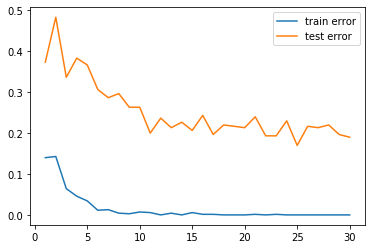

In [15]:
# Vaš kôd ovdje

train_errors=list()
test_errors=list()
L=range(1,31)
for i in L:
    rf_model=RandomForestClassifier(n_estimators=i).fit(X_bag_train, y_bag_train)
    train_prediction=rf_model.predict(X_bag_train)
    train_error=zero_one_loss(train_prediction,y_bag_train)
    train_errors.append(train_error)
    
    test_prediction=rf_model.predict(X_bag_test)
    test_error=zero_one_loss(test_prediction,y_bag_test)
    test_errors.append(test_error)
    

print("Minimal test error:\t",min(test_errors)) 

    
plt.plot(L, train_errors, label='train error')
plt.plot(L, test_errors, label='test error')    
plt.legend()
plt.show()    

**Q:** Što možete zaključiti iz ovih grafikona?  
**Q:** Kako *bagging* postiže diverzifikaciju pojedinačnih osnovnih modela?  
**Q:** Koristi li ovaj algoritam složeni ili jednostavni osnovni model? Zašto?

### 3. Ansambli (*boosting*)

U ovom zadatku pogledat ćemo klasifikacijski algoritam AdaBoost, koji je implementiran u razredu [`ensemble.AdaBoostClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html). Ovaj algoritam tipičan je predstavnik *boosting*-algoritama.

Najprije ćemo generirati eksperimentalni skup podataka koristeći [`datasets.make_circles`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html). Ova funkcija stvara dvodimenzijski klasifikacijski problem u kojem su dva razreda podataka raspoređena u obliku kružnica, tako da je jedan razred unutar drugog.

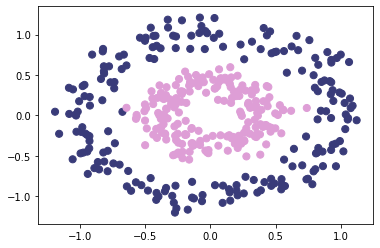

In [21]:
from sklearn.datasets import make_circles

circ_X, circ_y = make_circles(n_samples=400, noise=0.1, factor=0.4)
mlutils.plot_2d_clf_problem(circ_X, circ_y)

#### (a)

*Boosting*, kao vrsta ansambla, također se temelji na kombinaciji više klasifikatora s ciljem boljih prediktivnih sposobnosti. Međutim, ono što ovakav tip ansambla čini zanimljivim jest to da za osnovni klasifikator traži **slabi klasifikator** (engl. *weak classifier*), odnosno klasifikator koji radi tek malo bolje od nasumičnog pogađanja. Često korišteni klasifikator za tu svrhu jest **panj odluke** (engl. *decision stump*), koji radi predikciju na temelju samo jedne značajke ulaznih primjera. Panj odluke specijalizacija je **stabla odluke** (engl. *decision tree*) koje smo već spomenuli. Panj odluke stablo je dubine 1. Stabla odluke implementirana su u razredu [`tree.DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

Radi ilustracije, naučite ansambl (AdaBoost) koristeći panj odluke kao osnovni klasifikator, ali pritom isprobavajući različit broj klasifikatora u ansamblu iz skupa $L \in \{1, 2, 3, 50\}$. Prikažite decizijske granice na danom skupu podataka za svaku od vrijednosti korištenjem pomoćne funkcije `mlutils.plot_2d_clf_problem`.

**NB:** Još jedan dokaz da hrvatska terminologija zaista može biti smiješna. :)

In [22]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

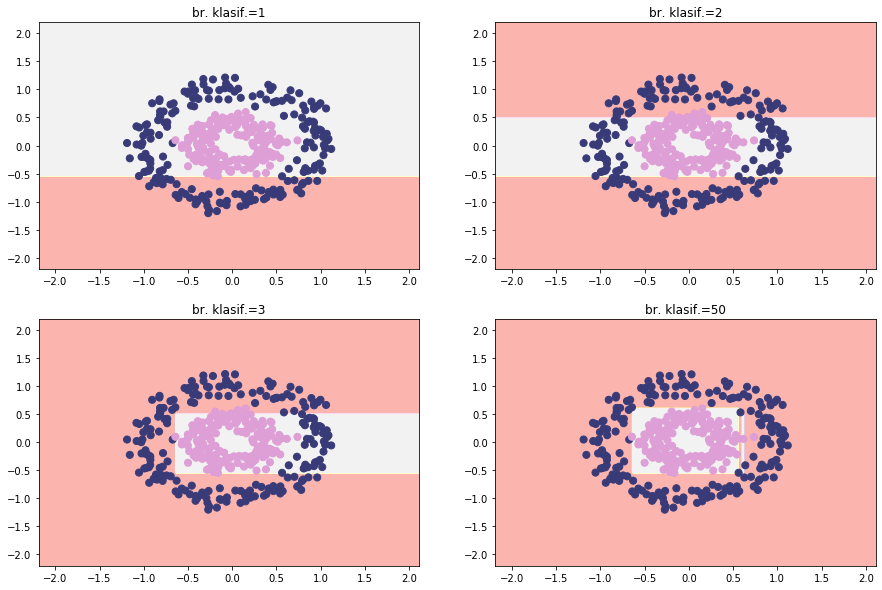

In [23]:
# Vaš kôd ovdje

decision_tree_model=DecisionTreeClassifier(max_depth=1)
L=[1,2,3,50]
plt.figure(figsize=(15, 10))
for i,l in enumerate(L):
    adaBoost_model=AdaBoostClassifier(base_estimator=decision_tree_model, n_estimators=l).fit(circ_X, circ_y)
    prediction=adaBoost_model.predict
    plt.subplot(2, 2, i+1)
    plt.title("br. klasif.="+str(l))
    mlutils.plot_2d_clf_problem(circ_X, circ_y, prediction)


**Q:** Kako AdaBoost radi? Ovise li izlazi pojedinih osnovnih modela o onima drugih?  
**Q:** Je li AdaBoost linearan klasifikator? Pojasnite.

#### (b)

Kao što je i za očekivati, broj klasifikatora $L$ u ansamblu predstavlja hiperparametar algoritma *AdaBoost*. U ovom zadatku proučit ćete kako on utječe na generalizacijsku sposobnost Vašeg ansambla. Ponovno, koristite panj odluke kao osnovni klasifikator.

Poslužite se skupom podataka koji je dan niže.

In [24]:
from sklearn.model_selection import train_test_split

X_boost, y_boost = make_classification(n_samples=1000, n_features=20, n_redundant=0, n_informative=18, n_classes=3, n_clusters_per_class=1)
X_boost_train, X_boost_test, y_boost_train, y_boost_test = train_test_split(X_boost, y_boost, train_size=0.7, random_state=69)

Iscrtajte krivulje pogrešaka na skupu za učenje i ispitivanje u ovisnosti o hiperparametru $L \in [1,80]$. Koristite pogrešku 0-1 iz paketa [`metrics`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics). Ispišite najmanju ostvarenu pogrešku na skupu za ispitivanje, te pripadajuću vrijednost hiperparametra $L$.

Minimal test error:	 0.2633333333333333
Best L:	 34


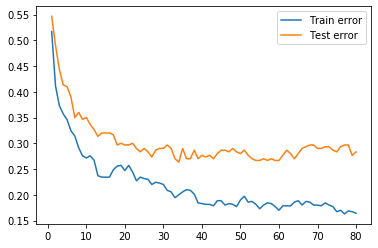

In [25]:
# Vaš kôd ovdje
L=list(range(1,81))
train_errors=list()
test_errors=list()

dt_model=DecisionTreeClassifier(max_depth = 1)
for l in L:
    adaBoost_model=AdaBoostClassifier(base_estimator=dt_model, n_estimators=l).fit(X_boost_train, y_boost_train)
    
    prediction=adaBoost_model.predict(X_boost_train)
    train_error=zero_one_loss(y_boost_train, prediction)
    train_errors.append(train_error)
    
    prediction=adaBoost_model.predict(X_boost_test)
    test_error=zero_one_loss(y_boost_test, prediction)
    test_errors.append(test_error)

    
print("Minimal test error:\t",min(test_errors))
index=np.argmin(test_errors)
print ("Best L:\t",index+1)
    
plt.plot(L, train_errors, label="Train error")
plt.plot(L, test_errors, label="Test error")
plt.legend()
plt.show()


**Q:** Može li uopće doći do prenaučenosti pri korištenju *boosting*-algoritama?

#### (c)

Kao što je rečeno na početku, *boosting*-algoritmi traže slabe klasifikatore kako bi bili najefikasniji što mogu biti. Međutim, kako se takav ansambl mjeri s jednim **jakim klasifikatorom** (engl. *strong classifier*)? To ćemo isprobati na istom primjeru, ali korištenjem jednog optimalno naučenog stabla odluke.

Ispišite pogrešku ispitivanja optimalnog stabla odluke. Glavni hiperparametar stabala odluka jest njihova maksimalna dubina $d$ (parametar `max_depth`). Iscrtajte krivulje pogrešaka na skupu za učenje i ispitivanje u ovisnosti o dubini stabla $d \in [1,20]$.

Minimal test error:	 0.32333333333333336
Best depth:	 10


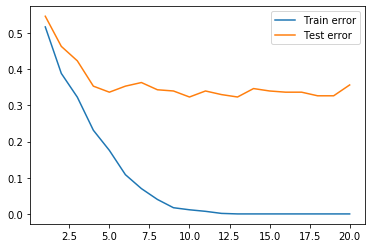

In [26]:
# Vaš kôd ovdje
depth=list(range(1,21))
train_errors=list()
test_errors=list()
for d in depth:
    dt_model=DecisionTreeClassifier(max_depth=d).fit(X_boost_train, y_boost_train)

    prediction=dt_model.predict(X_boost_train)
    train_error=zero_one_loss(y_boost_train, prediction)
    train_errors.append(train_error)
    
    prediction=dt_model.predict(X_boost_test)
    test_error=zero_one_loss(y_boost_test, prediction)
    test_errors.append(test_error)

print("Minimal test error:\t",min(test_errors))
index=np.argmin(test_errors)
print ("Best depth:\t",index+1)    
    
plt.plot(depth, train_errors, label="Train error")
plt.plot(depth, test_errors, label="Test error")
plt.legend()
plt.show()

**Q:** Isplati li se koristiti ansambl u obliku *boostinga*? Idu li grafikoni tome u prilog?<br>
**Q:** Koja je prednost *boostinga* nad korištenjem jednog jakog klasifikatora?

### 4. Procjena maksimalne izglednosti i procjena maksimalne aposteriorne vjerojatnosti

#### (a)

Definirajte funkciju izglednosti $\mathcal{L}(\mu|\mathcal{D})$ za skup $\mathcal{D}=\{x^{(i)}\}_{i=1}^N$ Bernoullijevih varijabli. Neka od $N$ varijabli njih $m$ ima vrijednost 1 (npr. od $N$ bacanja novčića, $m$ puta smo dobili glavu). Definirajte funkciju izglednosti tako da je parametrizirana s $N$ i $m$, dakle definirajte funkciju $\mathcal{L}(\mu|N,m)$. 

In [20]:
# Vaš kôd ovdje
def likelihood(mi,N,m):
    return pow(mi,m)*pow(1-mi,N-m)

#### (b)

Prikažite funkciju $\mathcal{L}(\mu|N,m)$ za (1) $N=10$ i $m=1,2,5,9$ te za (2) $N=100$ i $m=1,10,50,90$ (dva zasebna grafikona).

<Figure size 720x648 with 0 Axes>

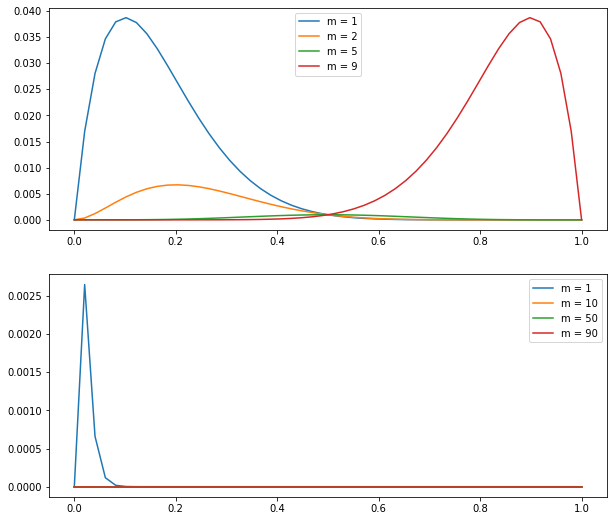

In [27]:
# Vaš kôd ovdje
mi=linspace(0,1)

plt.figure()
plt.figure(figsize(10,9))

#1
N=10
m_list=[1,2,5,9]
subplot(2, 1, 1)
for m in m_list:
    plt.plot(mi, likelihood(mi, N, m), label="m = "+str(m))
    plt.legend()
    
#2
N=100
m_list=[1,10,50,90]
subplot(2, 1, 2)
for m in m_list:
    plt.plot(mi, likelihood(mi, N, m), label="m = "+str(m))
    plt.legend()




**Q:** Koja vrijednost odgovara ML-procjenama i zašto?

#### (c)

Prikažite funkciju $\mathcal{L}(\mu|N,m)$ za $N=10$ i $m=\{0,9\}$.

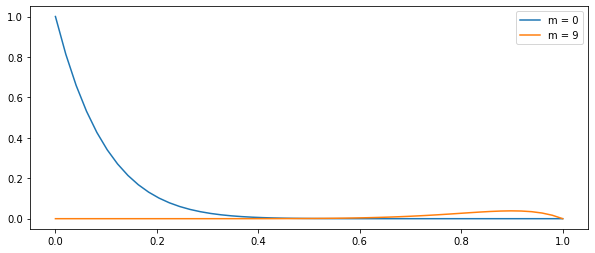

In [28]:
# Vaš kôd ovdje

N=10
m_list=[0,9]
subplot(2, 1, 1)
for m in m_list:
    plt.plot(mi, likelihood(mi, N, m), label="m = "+str(m))
    plt.legend()


**Q:** Koja je ML-procjena za $\mu$ i što je problem s takvom procjenom u ovome slučaju?

#### (d)

Prikažite beta-distribuciju $B(\mu|\alpha,\beta)$ za različite kombinacije parametara $\alpha$ i $\beta$, uključivo $\alpha=\beta=1$ te $\alpha=\beta=2$.

In [29]:
from scipy.stats import beta

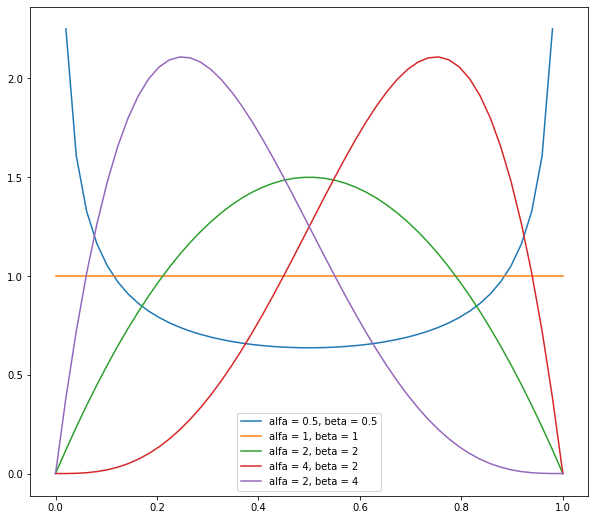

In [30]:
# Vaš kôd ovdje

alfas = [0.5, 1, 2, 4, 2]
betas = [0.5, 1, 2, 2, 4]
pairs=[]
pairs.extend(zip(alfas,betas))

for i,pair in enumerate(pairs):
    plt.plot(mi, beta.pdf(mi, pair[0], pair[1]), label = "alfa = "+str(pair[0])+", beta = "+str(pair[1]))
plt.legend()
plt.show()

**Q:** Koje parametere biste odabrali za modeliranje apriornog znanja o parametru $\mu$ za novčić za koji mislite da je "donekle pravedan, ali malo češće pada na glavu"? Koje biste parametre odabrali za novčić za koji držite da je posve pravedan? Zašto uopće koristimo beta-distribuciju, a ne neku drugu?

#### (e)

Definirajte funkciju za izračun zajedničke vjerojatnosti $P(\mu,\mathcal{D}) = P(\mathcal{D}|\mu) \cdot P(\mu|\alpha,\beta)$ te prikažite tu funkciju za $N=10$ i $m=9$ i nekolicinu kombinacija parametara $\alpha$ i $\beta$. 

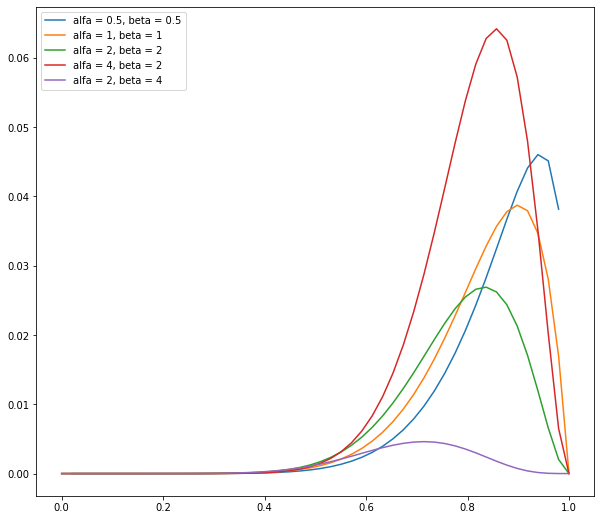

In [31]:
# Vaš kôd ovdje
def zajednicka_vjerojatnost(mi,N,m,a,b):
    return likelihood(mi,N,m)*beta.pdf(mi,a,b)

alfas = [0.5, 1, 2, 4, 2]
betas = [0.5, 1, 2, 2, 4]
pairs=[]
pairs.extend(zip(alfas,betas))

for i,pair in enumerate(pairs):
    plt.plot(mi, zajednicka_vjerojatnost(mi, 10, 9, pair[0], pair[1]), label = "alfa = "+str(pair[0])+", beta = "+str(pair[1]))
plt.legend()
plt.show()

**Q**: Koje vrijednosti odgovaraju MAP-procjeni za $\mu$? Usporedite ih sa ML-procjenama.

#### (f)

Za $N=10$ i $m=1$, na jednome grafikonu prikažite sve tri distribucije: $P(\mu,\mathcal{D})$, $P(\mu|\alpha,\beta)$ i $\mathcal{L}(\mu|\mathcal{D})$.

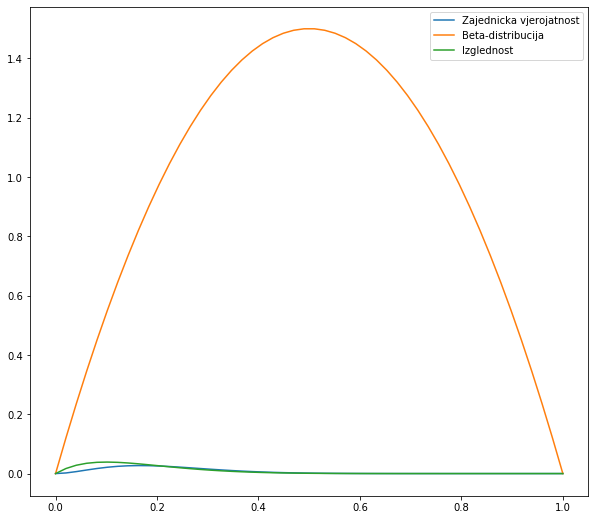

In [26]:
# Vaš kôd ovdje
N=10
m=1

plt.plot(mi, zajednicka_vjerojatnost(mi, N, m, 2, 2), label="Zajednicka vjerojatnost")
plt.plot(mi, beta.pdf(mi, 2, 2), label="Beta-distribucija")
plt.plot(mi, likelihood(mi, N, m), label="Izglednost")

plt.legend()
plt.show()

#### (g)

Pročitajte [ove](http://scikit-learn.org/stable/datasets/) upute o učitavanju oglednih skupova podataka. Učitajte skup podataka *Iris*. Taj skup sadrži $n=4$ značajke i $K=3$ klase. Odaberite jednu klasu i odaberite sve primjere iz te klase, dok ostale primjere zanemarite (**u nastavku radite isključivo s primjerima iz te jedne klase**). Vizualizirajte podatke tako da načinite 2D-prikaze za svaki par značajki (šest grafikona; za prikaz je najjednostavnije koristiti funkciju [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter)).

**NB:** Mogla bi Vam dobro dući funkcija [`itertools.combinations`](https://docs.python.org/2/library/itertools.html#itertools.combinations).

In [32]:
from sklearn.datasets import load_iris
import itertools as it


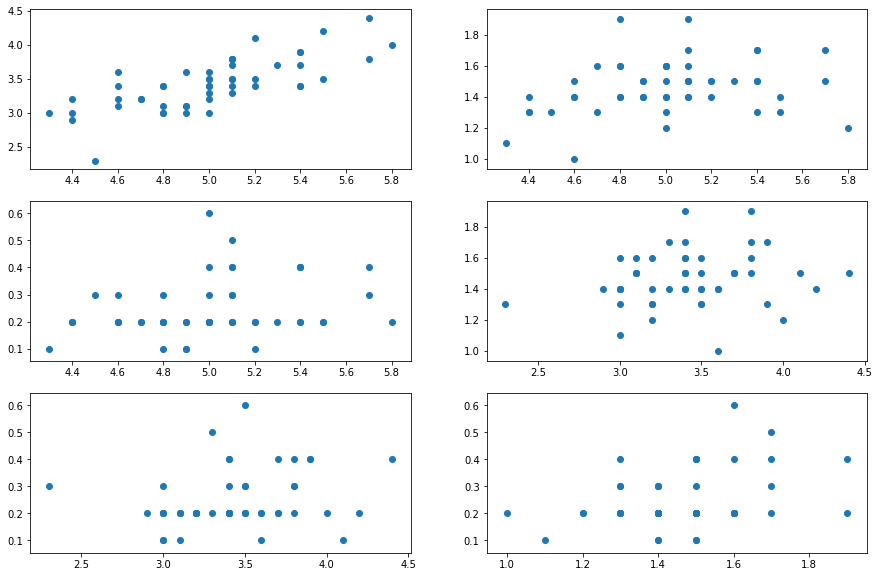

In [37]:
# Vaš kôd ovdje


dataset=load_iris()
y=dataset.target==0
X_iris=dataset.data[y]

plt.figure(figsize(15,10))
for k, (i, j) in enumerate(it.combinations(range(4), 2)):
    subplot(3, 2, k+1)
    scatter(X_iris[:,i], X_iris[:,j])

#### (h)

Pogledajte opis modul [`stats`](http://docs.scipy.org/doc/scipy-0.14.0/reference/stats.html) te proučite funkciju [`norm`](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.norm.html#scipy.stats.norm). Implementirajte funkciju log-izglednosti za parametre $\mu$ i $\sigma^2$ normalne distribucije.

In [38]:
from scipy.stats import norm

In [39]:
# Vaš kôd ovdje


def log_likelihood(mi, var, X):
    N=len(X)
    prvi_clan=N/2*log(2*pi)
    drugi_clan=N*log(sqrt(var))
    treci_clan=sum(pow(X-mi,2))/(2*var)
    
    return -(prvi_clan+drugi_clan+treci_clan)


#### (i)
Izračunajte ML-procjene za $(\mu, \sigma^2)$ za svaku od $n=4$ značajki iz skupa *Iris*. Ispišite log-izglednosti tih ML-procjena. 

In [40]:
# Vaš kôd ovdje

for i in range(4):
    X=X_iris[:,i]
    N=len(X)
    mi=sum(X)/N
    sigma=sum(pow(X-mi, 2))/N
    likelihood=log_likelihood(mi, sigma, X)
#     print("n="+str(i+1)+":\n mi="+str(mi)+", sigma="+str(sigma)+", logL="+str(likelihood))
    print ("n="+str(i+1)+": logL="+str(likelihood))

n=1: logL=-18.305163312803863
n=2: logL=-21.939396526466616
n=3: logL=17.08978609115976
n=4: logL=42.0646097912948


**Q:** Možete li, na temelju dobivenih log-izglednosti, zaključiti koja se značajka najbolje pokorava normalnoj distribuciji? 

#### (j)

Proučite funkciju [`pearsonr`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html) za izračun Pearsonovog koeficijenta korelacije. Izračunajte koeficijente korelacije između svih četiri značajki u skupu *Iris*. 

In [382]:
from scipy.stats import pearsonr

In [385]:
# Vaš kôd ovdje

for combination in (it.combinations(range(4), 2)):
    pearsonCoef=pearsonr(X_iris[:, combination[0]], X_iris[:, combination[1]])
    print (combination,": koef="+str(pearsonCoef))
  

(0, 1) : koef=(0.45722781639411314, 0.000843462472370877)
(0, 2) : koef=(0.8642247329355762, 6.29778575890394e-16)
(0, 3) : koef=(0.2811077091573194, 0.0479814933691886)
(1, 2) : koef=(0.40104457734278554, 0.0038977040683383264)
(1, 3) : koef=(0.5377280262661888, 5.64761040228772e-05)
(2, 3) : koef=(0.32210821590031835, 0.022535767279873883)


#### (k)

Proučite funkciju [`cov`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html) te izračunajte ML-procjenu za kovarijacijsku matricu za skup *Iris*. Usporedite pristranu i nepristranu procjenu. Pokažite da se razlika (srednja apsolutna i kvadratna) smanjuje s brojem primjera (npr. isprobajte za $N/4$ i $N/2$ i $N$ primjera).

In [387]:
# Vaš kôd ovdje

N = len(X_iris)
num_of_examples=[N,round(N/2),round(N/4)]

for n in num_of_examples:
    biased=cov(X_iris[0:n,:], bias=True,rowvar=False)
    not_biased=cov(X_iris[0:n,:], bias=False, rowvar=False)

    absolute_diff=mean(abs(biased-not_biased))
    square_diff=mean(pow(biased-not_biased,2))
    
    print("N=", n)
    print("Apsolutna razlika=", absolute_diff)
    print("Kvadratna razlika=", square_diff)

N= 50
Apsolutna razlika= 0.002645408163265291
Kvadratna razlika= 1.2466035360266395e-05
N= 25
Apsolutna razlika= 0.007054833333333316
Kvadratna razlika= 9.173363433333285e-05
N= 12
Apsolutna razlika= 0.013972143308080824
Kvadratna razlika= 0.0003439149450032212
